In [ ]:
%%capture
!pip install -U scikit-learn

# install phik (if not installed yet)
import sys
!"{sys.executable}" -m pip install phik

!pip install shap
import shap


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import seaborn as sns

# импортируем функцию
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from IPython.display import Image

# pipeline
# загружаем нужные классы
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# загружаем дополнительные классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    # добавьте нужное
    RobustScaler
)

# загрузите инструмент для автоподбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

# импортируем модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelEncoder


from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

<b>Описание проекта</b><br>
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.<br>
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. <br>
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. <br>
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. <br>
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.<br>


<font color='blue'> <h2> <b>Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:<br>
·	id — уникальный идентификатор сотрудника;<br>
·	dept — отдел, в котором работает сотрудник;<br>
·	level — уровень занимаемой должности;<br>
·	workload — уровень загруженности сотрудника;<br>
·	employment_years — длительность работы в компании (в годах);<br>
·	last_year_promo — показывает, было ли повышение за последний год;<br>
·	last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;<br>
·	supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;<br>
·	salary — ежемесячная зарплата сотрудника;<br>
·	job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.<br>


<font color='blue'> <h3> Шаг 1. Загрузка данных

<b>Тренировочная выборка: <br></b>
train_job_satisfaction_rate.csv<br>
<b>Входные признаки тестовой выборки:<br></b>
test_features.csv<br>
<b>Целевой признак тестовой выборки:<br></b>
test_target_job_satisfaction_rate.csv<br>

In [ ]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal = ',')
    test_features = pd.read_csv('/datasets/test_features.csv', decimal = ',')
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal = ',')

except:
    try:
        train_job_satisfaction_rate = pd.read_csv("train_job_satisfaction_rate.csv", decimal = ',')
        test_features = pd.read_csv("test_features.csv", decimal = ',')
        test_target_job_satisfaction_rate = pd.read_csv("test_target_job_satisfaction_rate.csv", decimal = ',')
    except:
        print("Unable to load data")

In [ ]:
# Посмотрим данные тренировочной базы
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


In [ ]:
# посмотрим информацию о тренировочной базе
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   job_satisfaction_rate  4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [ ]:
# Посмотри данные тестовой базы
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
# посмотрим информацию о тестовой базе
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
# # Посмотри данные таргета
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.6
3,555320,0.72
4,826430,0.08


In [ ]:
# посмотрим информацию о базе
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   job_satisfaction_rate  2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


- Выполнена загрузка данных трёх баз: <br><br>
<b>Тренировочная выборка: <br></b>
train_job_satisfaction_rate.csv :<br>
- 4000 строк, пропуски в столбцах: dept - 6, level - 4; <br>
- десять столбцов: пять категориальных, три цифровых, столбец с индексами клиентов и id
- данные в столбцах: dept, level,	workload имеют по несколько категорий - ранговые; <br>
- данные в столбцах: last_year_promo, last_year_violations - бинарные категориальные; <br>
- оценка руководителя: supervisor_evaluation - цифровые дискретные; <br>
- столбец job_satisfaction_rate - таргет: цифровой квази непрерывный. Тип object не соответсвует 'float64'.<br>
<br>
<b>Входные признаки тестовой выборки:<br></b>
test_features.csv :<br>
- Данные соответствуют тренировочной базе;
- Пропорции пропусков не равны;<br>
- 2000 строк, пропуски в столбцах: dept - 2, level - 1; <br><br>
<br>
<b>Целевой признак тестовой выборки:<br></b>
test_target_job_satisfaction_rate.csv - в базе один столбец job_satisfaction_rate - таргет.<br>
- Данные соответствуют тренировочной базе.
- - столбец job_satisfaction_rate - таргет: цифровой квази непрерывный. Тип object не соответсвует 'float64'.

<font color='blue'> <h3> Шаг 2. Предобработка данных

1) Заменим значения object на 'float64' в целевом признаке для анализа распределения.<br>
<br>
2) Пустые значения в столбцах будем заменять автоматически:<br>
В столбцах с категориальными значениями с помощью - unknown_value=np.nan.<br>
 <br>
 ordinal_encoder = OrdinalEncoder(<br>
    handle_unknown='use_encoded_value',<br>
    unknown_value=np.nan<br>
)<br>
<br>
SimpleImputer<br>
Чтобы заменить пропуск понадобится инструмент SimpleImputer из модуля impute в sklearn. В SimpleImputer реализованы основные стратегии для восстановления пропусков. Например, можно заменить недостающие значения на медиану, константу и не только. При инициализации класса используем два параметра:<br>
simple_imputer = SimpleImputer(<br>
    missing_values=np.nan,<br>
    strategy='most_frequent'<br>
) <br>
<br>
·	missing_values — указываем, что считать пропуском, например np.nan.<br>
·	strategy — стратегия заполнения пропусков: среднее mean, медиана median, мода most_frequent или константа constant. В случае с категориальным признаком логичнее использовать моду — самое частотное значение в выборке.<br>


In [ ]:
# заменим тип данных
train_job_satisfaction_rate['job_satisfaction_rate'] = train_job_satisfaction_rate['job_satisfaction_rate'].astype('float64')
test_target_job_satisfaction_rate['job_satisfaction_rate'] = test_target_job_satisfaction_rate['job_satisfaction_rate'].astype('float64')

In [ ]:
# контроль наличия критического количества дубликатов
train_job_satisfaction_rate.duplicated().sum(), test_features.duplicated().sum(), test_target_job_satisfaction_rate.duplicated().sum()

(0, 0, 0)

Заменим пробелы

In [ ]:
# Заменим пробел на nan
test_features['dept'] = test_features['dept'].replace(r'^\s*$', np.nan, regex=True)
print(test_features.sort_values('dept', ascending=False)['dept'].unique())

['technology' 'sales' 'purchasing' 'marketing' 'hr' nan]


In [ ]:
# Заменим пробел на nan
test_features['workload'] = test_features['workload'].replace(r'^\s*$', np.nan, regex=True)
print(test_features.sort_values('workload', ascending=False)['workload'].unique())

['medium' 'low' 'high' nan]


Аномалия обработана корректно. В целом она могла бы быть обработана и в `Pipeline`, при настройке энкодеров на обработку новых значений признаков, которые не были на момент обучения энкодера.

<font color='blue'> <h3> Шаг 3. Исследовательский анализ данных

In [ ]:
# статистическое распределение цирфовых данных
train_job_satisfaction_rate.describe(percentiles = [0.25, 0.50, 0.75])

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


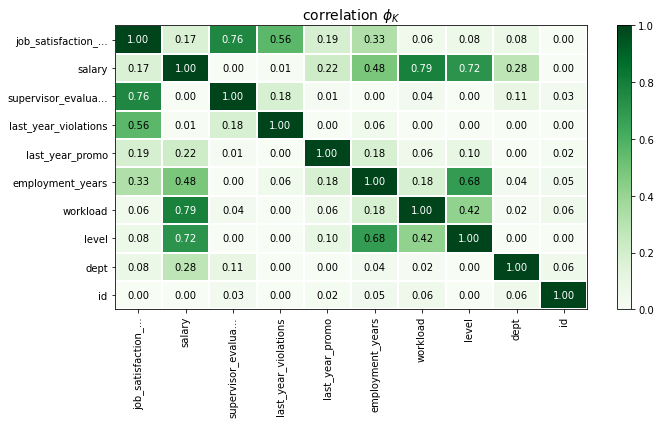

In [ ]:
# корреляционный анализ всех признаков
interval_cols = train_job_satisfaction_rate.select_dtypes(include=["number"]).columns[0:11]

phik_overview = phik_matrix(train_job_satisfaction_rate, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(10, 6)
)

4000 значений, данные релевантны, мультиколлинеарные признаки отсутствуют

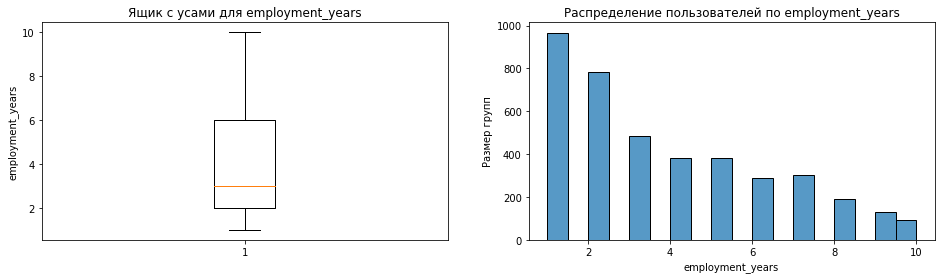

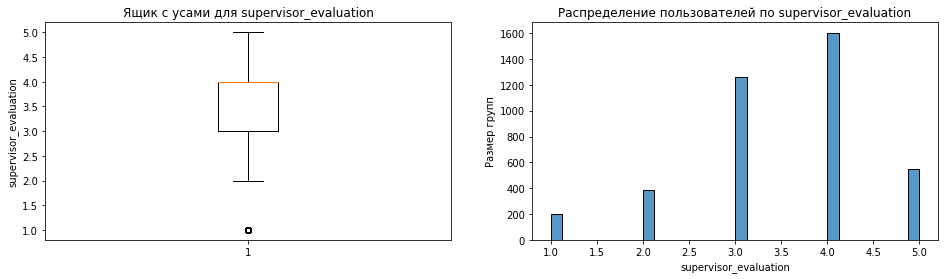

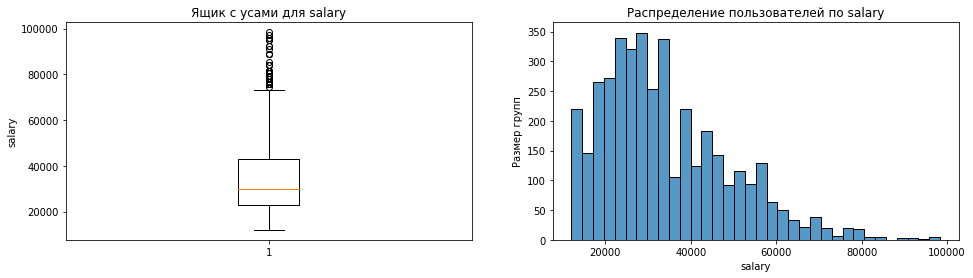

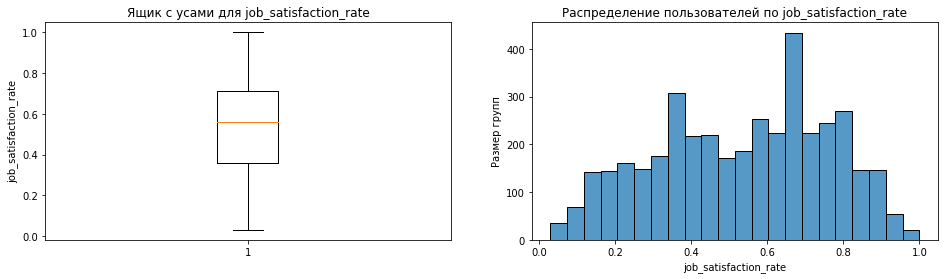

In [ ]:
# вывод графического отображения цифровых данных из табилцы market_file.scv
def boxplot_hist_figure(categories):

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    axes[0].boxplot(train_job_satisfaction_rate[categories])
    axes[0].set_title("Ящик с усами для "+str(categories))
    axes[0].set_ylabel(str(categories));

    sns.histplot(data=train_job_satisfaction_rate, x=categories)
    axes[1].set_xlabel(str(categories))
    axes[1].set_ylabel("Размер групп")
    axes[1].set_title("Распределение пользователей по "+str(categories));

# Список названий столбцов имеющих числовые признаки
numeric_list = train_job_satisfaction_rate.select_dtypes(include=["number"]).columns[1:11]

# С помощью цикла выведем все графики
for categories in numeric_list:
    boxplot_hist_figure(categories)

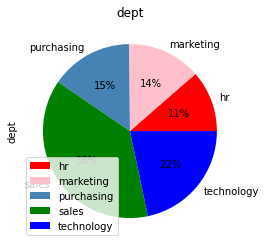

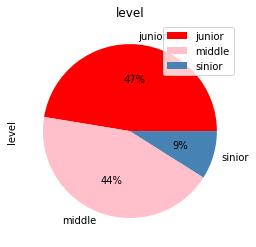

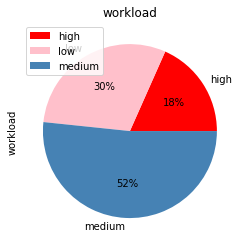

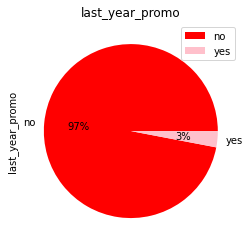

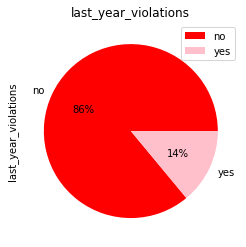

In [ ]:
# подсчёт распределений категориальных значений
def set_categories(categories):
    table = pd.pivot_table(train_job_satisfaction_rate, values='id', index=[categories], aggfunc="count")
    table=table.rename(columns ={'id': categories})
    table.plot(kind='pie', y=categories, autopct='%1.0f%%', colors = ['red', 'pink', 'steelblue', 'green', 'blue'], title=str(categories))
    print()

# Список названий столбцов имеющих категориальные признаки
categoriesc_list = train_job_satisfaction_rate.select_dtypes(include=['object']).columns[0:11]

# С помощью цикла выведем все графики
for categories in categoriesc_list:
    set_categories(categories)

<b>Вывод о данных согласно задаче:</b><br>
1) Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. <br>
2) Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.<br>
3) Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). <br>
<br>

<b> Целевой признак имеет количественное значение, поэтому это задача регрессии. Также ее можно решить с помощью дерева решений</b><br><br>

<br>
<b> Перечислим особенности данных:</b><br>
1.	Признаки: last_year_promo (повышение), last_year_violations (нарушения), dept (отдел) — нужно кодировать с помощью OrdinalEncoder. («порядковый кодировщик») — кодируем с помощью OneHotEncoder<br>
2.	Два признака: level (уровень должности), workload (загруженность) — будем кодировать с помощью OrdinalEncoder. <br>
3. При таком кодировани получится значительное количество категорий, которые можно ученьшить с помощью L1-регуляризации.
<br>
4.	В признаках, закодированных этими методами, встречаются пропуски, которые будут автоматически заменены на моду<br>
5.	Признаков с утечкой целевого признака нет.<br>
6.	Количественные категории нужно масштабировать: employment_years (стаж), supervisor_evaluation (оценка), salary (зарплата)<br>
7.	Целевой признак job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак. Имеет непрерывное численное значение.

<font color='blue'> <h3> Шаг 4. Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитём особенности признаков и моделей и используем как минимум два кодировщика.


In [ ]:
# список категориальных значений
categoriesc_list = train_job_satisfaction_rate.select_dtypes(include=['object']).columns[0:11]
categoriesc_list

Index(['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'], dtype='object')

In [ ]:
# список цифровых значений
numeric_list = train_job_satisfaction_rate.select_dtypes(include=["number"]).columns[1:11]
numeric_list

Index(['employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

Исправим порядок в тестовых данных, объединением таблицы test_features и test_target_job_satisfaction_rate по id

In [ ]:
df_test = test_features.merge(test_target_job_satisfaction_rate, how = 'left', left_on='id', right_on='id')
df_test.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79


In [ ]:
# Сегментируем данные для предобрабоки и обучения модели
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate', 'id'], axis = 1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = df_test.drop(['job_satisfaction_rate', 'id'], axis = 1)
y_test = df_test['job_satisfaction_rate']

In [ ]:
# Pipeline для подготовки данных
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) # игнорирует «проблемные» объекты
        ),
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создайте общий пайплайн для подготовки данных
data_preprocessor1 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder = 'passthrough'
)

data_preprocessor1.fit(X_train, y_train)

print(data_preprocessor1)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  Ord

In [ ]:
# оценим преобразования
X_train_p = pd.DataFrame(
    data_preprocessor1.transform(X_train),
    columns=data_preprocessor1.get_feature_names_out()
)
X_test_p = pd.DataFrame(
    data_preprocessor1.transform(X_test),
    columns=data_preprocessor1.get_feature_names_out()
)

X_train_p.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.675991,-2.455174,-0.666273
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.675991,1.510381,0.300245
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.069351,-1.463785,-1.471705
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.110731,-1.463785,-1.068989
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.069351,-0.472397,-0.746816


<font color='blue'> <h3> Шаг 5. Обучение моделей

Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.
Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).

<font color='blue'> <h4> Деревья и линейная регрессия с метрикой SMAPE

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor

RANDOM_STATE =42
# пайплайн: подготовка данных

pipe_final1 = Pipeline([
    ('preprocessor', data_preprocessor1),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid1 = [
   # словарь для модели DecisionTreeClassifier()
   {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 5)
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()]
    },

]

def smape(y_test, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_test) / ((np.abs(y_pred) + np.abs(y_test))/2))

smape_scorer1 = make_scorer(smape, greater_is_better=False)

gs1 = GridSearchCV(
    pipe_final1,
    param_grid=param_grid1,
    cv=5,
    scoring=smape_scorer1,
    n_jobs=-1
)

Задаём параметр `greater_is_better=False`. Дело в том, что разработчики пакета `sklearn` при создании функций `cross_val_score` и `GridSearchCV` утвердили соглашение: возвращаемые результаты вычислений данных функций должны соответствовать задаче максимизации (чем большее значение метрики получаем, тем лучше). При этом обратная задача минимизации может быть осуществлена через максимизацию метрики, домноженной на -1. Об этом можно чуть подробнее почитать в документации пакета, правда она на английском.  <a href = 'https://scikit-learn.org/stable/modules/model_evaluation.html'>Ссылка</a>.

<font color='blue'> <h4> Выполним предсказание на тестовой выбоке. Посчитаем метрику SMAPE

Определим в трениворочных и тестовых выборках целевые признаки. Использование train_test_split не нужно, т.к. тестовая и трениворочная выборка заданы в отдельных файлах.

In [ ]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis = 1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = df_test.drop(['id', 'job_satisfaction_rate'], axis = 1)
y_test = df_test['job_satisfaction_rate']

In [ ]:
gs1.fit(X_train, y_train)

print('\n Лучшая модель и её параметры:\n\n', gs1.best_estimator_)
print ('\n Метрика лучшей модели на кроссвалидационной выборке:', gs1.best_score_)
print("\n Лучшие значения гиперпараметров:\n", gs1.best_params_)
print(f'\n Метрика SMAPE на тестовой выборке: {smape(y_test, gs1.predict(X_test)):.2f}')


 Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                          

<b> Критерий успеха: SMAPE ≤15 на тестовой выборке. Соответствует </b>

In [ ]:
# Оценим преобразованные данные
model = gs1.best_estimator_.named_steps['models']
df_named =pd.DataFrame(gs1.best_estimator_['preprocessor'].transform(X_train),
                        columns=gs1.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
df_named.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.675991,-2.455174,-0.666273
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.675991,1.510381,0.300245
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.069351,-1.463785,-1.471705
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.110731,-1.463785,-1.068989
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.069351,-0.472397,-0.746816


In [ ]:
#Выведем коэффициенты важности признаков лучшей модели
feature_importances = pd.DataFrame({'Feature': df_named.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
feature_importances.sort_values('Importance', ascending=False)

,Feature,Importance
9,num__supervisor_evaluation,0.673788
10,num__salary,0.084266
8,num__employment_years,0.075407
5,ohe__last_year_violations_yes,0.050793
6,ord__level,0.048993
7,ord__workload,0.019377
2,ohe__dept_sales,0.012637
4,ohe__last_year_promo_yes,0.011120
3,ohe__dept_technology,0.010672
0,ohe__dept_marketing,0.009895


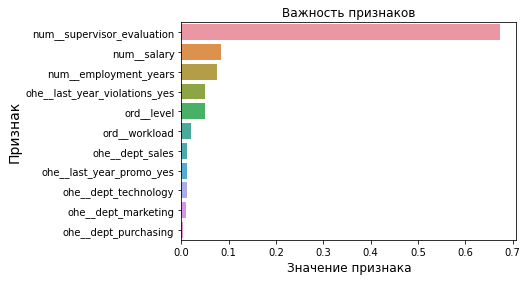

In [ ]:
#Построим график важности признаков лучшей модели
ax = sns.barplot(data=feature_importances, x='Importance', y='Feature')

# добавляем названия графика и осей
ax.set_title('Важность признаков', fontsize=12)
ax.set_xlabel('Значение признака', fontsize=12)
ax.set_ylabel('Признак', fontsize=14)

# отображаем график
plt.show();

<font color='blue'> <h3> Шаг 6. Оформление выводов

Проведен поиск лучшей модели с помощью пайплайна через метрику SMAPE.<br>
Лучшей моделью оказалось дерево решений с параметрами: <br>
{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2}<br>

Линейные модели хорошо решают задачи в которых есть незначительный выброс в данных. Для этой задачи она в меньшей степени соответствовала, чем "дерево решений", которое фактически разгруппировало характеристики по группам, а при решении просто сопостовляло с этими группами.<br>

* Дополнительно впоследствии можно заново пересобирать лучшую модель на ограниченном наборе признаков (а не заранее, чтобы была возможность контролировать спад качества), чтобы облегчить ее (может потребоваться заново подобрать параметры). Это может дать небольшой прирост в качестве за счет избавления от зашумленности, главное не переборщить.


Посмотрим на оценки моделей:

In [ ]:
result = pd.DataFrame(gs1.cv_results_)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

     rank_test_score                            param_models  mean_test_score  \
152                1  DecisionTreeRegressor(random_state=42)       -14.288852   
151                1  DecisionTreeRegressor(random_state=42)       -14.288852   
150                1  DecisionTreeRegressor(random_state=42)       -14.288852   
162                4  DecisionTreeRegressor(random_state=42)       -14.309892   
163                4  DecisionTreeRegressor(random_state=42)       -14.309892   
..               ...                                     ...              ...   
3                205  DecisionTreeRegressor(random_state=42)       -23.616754   
2                205  DecisionTreeRegressor(random_state=42)       -23.616754   
1                205  DecisionTreeRegressor(random_state=42)       -23.616754   
11               205  DecisionTreeRegressor(random_state=42)       -23.616754   
216              217                      LinearRegression()       -25.028455   

                           

<font color='blue'> <h2> <b>Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

<font color='blue'> <h3> Шаг 1. Загрузка данных

<b>Тренировочная выборка:</b><br>
train_quit.csv<br>
<b>Входные признаки тестовой выборки те же, что и в прошлой задаче:</b><br>
test_features.csv<br>
<b>Целевой признак тестовой выборки:</b><br>
test_target_quit.csv<br>

In [ ]:
# Загрузим данные с учётом разделителей
train_quit = pd.read_csv('/datasets/train_quit.csv', decimal = ',')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [ ]:
# Загрузим данные с учётом разделителей
test_features = pd.read_csv('/datasets/test_features.csv', decimal = ',')
test_features.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800


In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
# Загрузим данные с учётом разделителей
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', decimal = ',')
test_target_quit.head(1)

,id,quit
0,999029,yes


In [ ]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


- Выполнена загрузка данных трёх баз: <br><br>
<b>Тренировочная выборка: <br></b>
train_quit.csv :<br>
- 4000 строк, пропуски в столбцах: dept - 6, level - 4; <br>
- десять столбцов: пять категориальных, три цифровых, столбец с индексами клиентов и id
- данные в столбцах: dept, level,	workload имеют по несколько категорий - ранговые; <br>
- данные в столбце: dept имеют несколько номинальных категорий; <br>
- данные в столбцах: last_year_promo, last_year_violations - бинарные категориальные; <br>
- оценка руководителя: supervisor_evaluation - цифровые дискретные; <br>
- столбец quit - таргет: цифровой бинарный;<br>
- типы данных соответствуют содержанию.
<br>
<b>Входные признаки тестовой выборки:<br></b>
test_features.csv :<br>
- Данные соответствуют тренировочной базе;
- Пропорции пропусков не равны;<br>
- 2000 строк, пропуски в столбцах: dept - 2, level - 1; <br><br>
<br>
<b>Целевой признак тестовой выборки:<br></b>
test_target_quit - в базе один столбец quit - таргет.<br>
- Данные соответствуют тренировочной базе.
- - столбец quit - таргет:  цифровой бинарный.

<font color='blue'> <h3> Шаг 2. Предобработка данных

Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [ ]:
# Проверим соответствие индексов в двух базах test_target_job_satisfaction_rate и test_target_quit
test_target_job_satisfaction_rate.reset_index()['id'][~test_target_quit['id'].isin(test_target_job_satisfaction_rate.reset_index()['id'])]

Series([], Name: id, dtype: int64)

In [ ]:
# Проверим соответствие индексов в двух базах test_target_job_satisfaction_rate и test_target_quit
test_features.reset_index()['id'][~test_target_quit['id'].isin(test_features.reset_index()['id'])]

Series([], Name: id, dtype: int64)

Данные тестовых баз соответствуют друг другу по id

In [ ]:
# контроль наличия критического количества дубликатов
train_quit.duplicated().sum(), test_features.duplicated().sum(), test_target_quit.duplicated().sum()

(0, 0, 0)

In [ ]:
# статистическое распределение цирфовых данных
train_quit.describe(percentiles = [0.25, 0.50, 0.75])

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


Статистический анализ не выявил аномалий

Информация изучена - предобработка не трубуется. Пропуски будут заменены на моду автоматически на этапе масштабирования и кодирования данных.

<font color='blue'> <h3> Шаг 3. Исследовательский анализ данных

<font color='blue'> <h4> 3.1. Проведите исследовательский анализ данных.

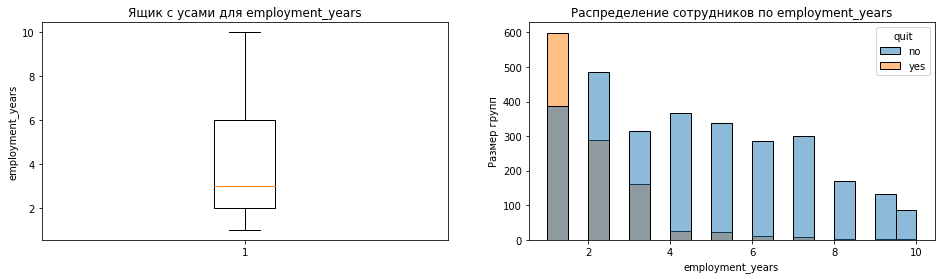

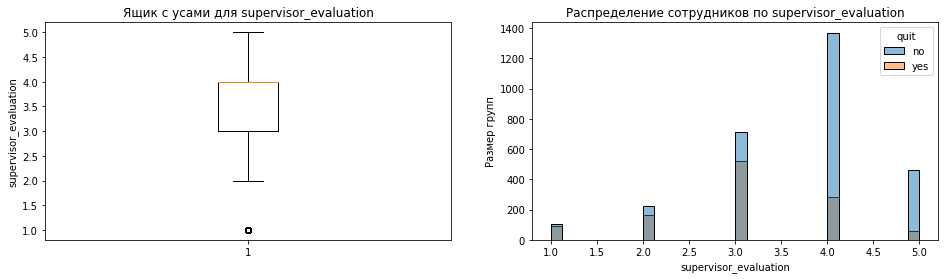

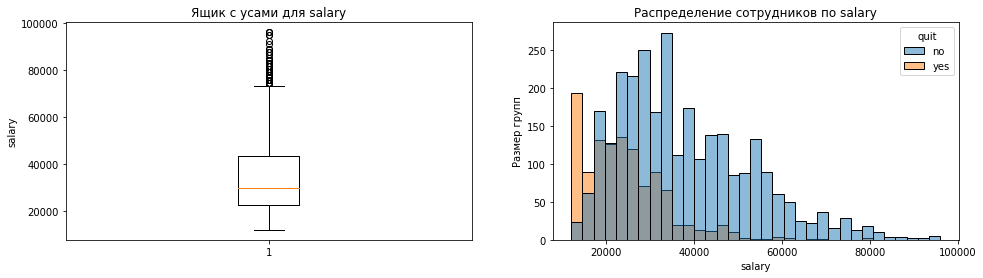

In [ ]:
# вывод графического отображения цифровых данных из табилцы market_file.scv
def boxplot_hist_figure(categories):

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    axes[0].boxplot(train_quit[categories])
    axes[0].set_title("Ящик с усами для "+str(categories))
    axes[0].set_ylabel(str(categories));

    sns.histplot(data=train_quit, x=categories, hue='quit')
    axes[1].set_xlabel(str(categories))
    axes[1].set_ylabel("Размер групп")
    axes[1].set_title("Распределение сотрудников по "+str(categories));

# Список названий столбцов имеющих числовые признаки
numeric_list = train_quit.select_dtypes(include=["number"]).columns[1:11]

# С помощью цикла выведем все графики
for categories in numeric_list:
    boxplot_hist_figure(categories)

1. Данные повторяют структуру первого исследования. <br>
2. Данные исследуемого параметры несбалансированы, нужно учесть при подготовке данных. <br>

<font color='blue'> <h4> 3.2. Составьте портрет «уволившегося сотрудника». </h4></font> <br>
Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

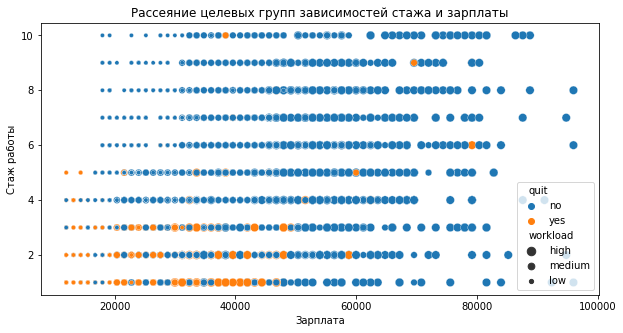

In [ ]:
# диаграммы рассеяния по увольнениям
plt.figure(figsize = (10,5))
sns.scatterplot(x ='salary', y ='employment_years', data = train_quit, hue ='quit', size='workload')
plt.title('Рассеяние целевых групп зависимостей стажа и зарплаты');
plt.xlabel("Зарплата")
plt.ylabel("Стаж работы");

Увольняющиеся находятся в основном в левом нижнем углу. Этап приработки в организации.<br>
Точки в других местах, карьерные перемещения.

In [ ]:
# подсчёт распределений уволенных и работающих по категориям
def set_categories(categories):
    print(categories)
    cat1 = train_quit[train_quit['quit']=='no'].groupby([categories]).agg({'id' : 'count'}).rename(columns ={'id': 'no'})
    cat2 = train_quit[train_quit['quit']=='yes'].groupby([categories]).agg({'id' : 'count'}).rename(columns ={'id': 'yes'})
    yes_no_dept = cat1.join(cat2, rsuffix = 'outer')
    yes_no_dept['proportion'] = yes_no_dept['yes']/yes_no_dept['no']
    print(yes_no_dept)
    print()
# Список названий столбцов имеющих категориальные признаки
categoriesc_list = train_quit.select_dtypes(include=['object']).columns[0:5]

# С помощью цикла выведем все графики
for categories in categoriesc_list:
    set_categories(categories)

dept
              no  yes  proportion
dept                             
hr           348  116    0.333333
marketing    419  163    0.389021
purchasing   422  166    0.393365
sales       1031  407    0.394762
technology   652  276    0.423313

level
          no   yes  proportion
level                         
junior   946  1003    1.060254
middle  1586   108    0.068096
sinior   340    17    0.050000

workload
            no  yes  proportion
workload                       
high       553  121    0.218807
low        689  519    0.753266
medium    1630  488    0.299387

last_year_promo
                   no   yes  proportion
last_year_promo                        
no               2760  1127    0.408333
yes               112     1    0.008929

last_year_violations
                        no  yes  proportion
last_year_violations                       
no                    2555  900    0.352250
yes                    317  228    0.719243



Максимальное соотношение уволившихся к работающим в следующих категориях (группы риска): <br>
dept: technology - 0,42<br>
level: junior - 1,06<br>
workload: low - 0,75<br>
last_year_promo: без повышения 0,41; с повышением 0,01<br>
last_year_violations: без нарушений 0,35; с нарушениями 0,72<br>

<font color='blue'> <h4> 3.3. Уровень удовлетворённости сотрудника  </h4></font> <br>

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [ ]:
# отсортируем сотрудников на пять групп по ощущениям в работе, соответсвующих диапазонов их оценок
def job_satisfaction_rate(rate):

    if 0 < rate <= 0.2:
        return 'плохо'
    if 0.2 < rate <= 0.4:
        return 'удовл.'
    if 0.4 < rate <= 0.6:
        return 'хорошо'
    if 0.6 < rate <= 0.8:
        return 'доволен'
    if 0.8 < rate <= 1.0:
        return 'отлично'

test_target_job_satisfaction_rate['rate'] = test_target_job_satisfaction_rate['job_satisfaction_rate'].apply(job_satisfaction_rate)
test_target_job_satisfaction_rate.groupby('rate')['rate'].count()

rate
доволен    732
отлично    222
плохо      167
удовл.     415
хорошо     464
Name: rate, dtype: int64

In [ ]:
test_target_job_satisfaction_rate.head(1)

,id,job_satisfaction_rate,rate
0,130604,0.74,доволен


In [ ]:
test_target_quit.head(1)

,id,quit
0,999029,yes


In [ ]:
train_quit_rate = pd.merge(test_target_job_satisfaction_rate, test_target_quit, on='id', how='outer')
train_quit_rate.head()

,id,job_satisfaction_rate,rate,quit
0,130604,0.74,доволен,no
1,825977,0.75,доволен,no
2,418490,0.60,хорошо,yes
3,555320,0.72,доволен,no
4,826430,0.08,плохо,yes


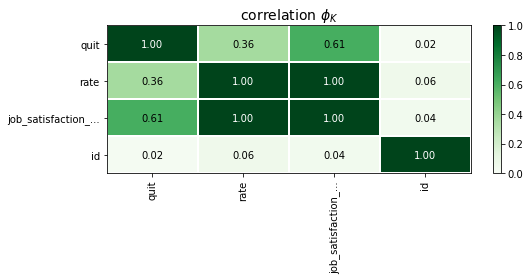

In [ ]:
# корреляционный анализ признаков удовлетворенности
interval_cols = train_quit_rate.select_dtypes(include=["number"]).columns[0:11]

phik_overview = phik_matrix(train_quit_rate, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(8, 4)
)

Средний уровень корреляции оценки руководителя и увольнений

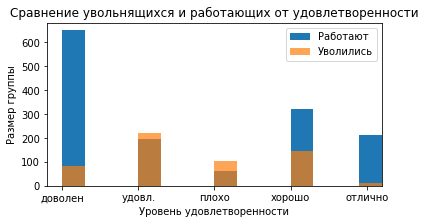

In [ ]:
# построить гистограммы
fig, axes = plt.subplots(1, figsize=(6, 3))

plt.hist(train_quit_rate[train_quit_rate['quit'] == 'no']['rate'], bins=40, alpha = 1, width = 0.3)
plt.hist(train_quit_rate[train_quit_rate['quit'] == 'yes']['rate'], bins=40, alpha = 0.7, width = 0.3)
plt.xlabel('Уровень удовлетворенности')
plt.ylabel("Размер группы")
plt.legend(["Работают", "Уволились"])
plt.title("Сравнение увольнящихся и работающих от удовлетворенности");

На графике видна зависимость удовлетворенности сотрудника и его рабочего статуса. Зависимость подтверждена.

<font color='blue'> <h3> Шаг 4. Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [ ]:
# предскажем оценку удовлетворённости на основе общих характеристик сотрудника в тренировочной базе
y_pred_train = gs1.predict(train_quit.drop(['id', 'quit'], axis=1))
y_pred_train[0:5]

array([0.648     , 0.82190476, 0.3375    , 0.35      , 0.8125    ])

In [ ]:
train_quit['job_satisfaction_rate'] = y_pred_train
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.648000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.821905
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.337500
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.812500


In [ ]:
# предскажем оценку удовлетворённости на основе общих характеристик сотрудника в тестовой базе
y_pred_test = gs1.predict(test_features.drop(['id'], axis=1))
y_pred_test[0:5]

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([0.88333333, 0.67666667, 0.68375   , 0.71333333, 0.815     ])

In [ ]:
test_features['job_satisfaction_rate'] = y_pred_test
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.883333
1,686555,hr,junior,medium,1,no,no,4,30000,0.676667
2,467458,sales,middle,low,5,no,no,4,19200,0.683750
3,418655,sales,middle,low,6,no,no,4,19200,0.713333
4,789145,hr,middle,medium,5,no,no,5,40800,0.815000


Исправим порядок в тестовых данных, для этого объединим таблицы test_features и test_target_quit по столбцу с id

In [ ]:
df_quit = test_features.merge(test_target_quit, how='left', on='id')
df_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.883333,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.676667,no
2,467458,sales,middle,low,5,no,no,4,19200,0.683750,no
3,418655,sales,middle,low,6,no,no,4,19200,0.713333,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.815000,no


<b>Новый признак добавлен

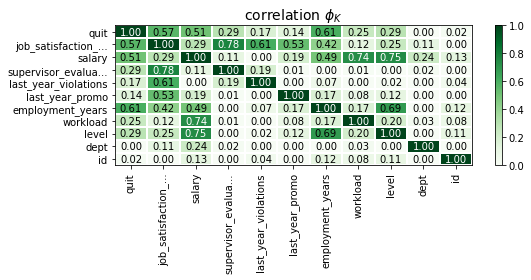

In [ ]:
# корреляционный анализ всех признаков
interval_cols = df_quit.select_dtypes(include=["number"]).columns[0:11]

phik_overview = phik_matrix(df_quit, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.0,
    figsize=(8, 4)
)

Мультиколлинеарных данных нет

Признак job_satisfaction_rate добавлен в тренировочную и тестовую выборки, а значения предсказаны с помощью лучшей модели регрессии, обученной в прошлой части задачи

<font color='blue'> <h3> Шаг 5. Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [ ]:
# Определим тестовые и тренировочные признаки
X_train2 =  train_quit.drop(['quit', 'id'], axis=1)
y_train2 = train_quit['quit']
X_test2 = df_quit.drop(['id', 'quit'], axis=1)
y_test2 = df_quit['quit']

При использовании OrdinalEncoder, если указывать ранговые значения, на выходе получим упорядоченный список категорий. Такая иерархия станет проблемой для линейных моделей. Алгоритм может подумать, что между категориями есть логичная математическая связь, хотя в действительности её нет. Между тем линейная модель данную задачу (разделить данные на два лагеря) может решить лучше других. Поэтому OrdinalEncoder будем использовать без указания рангов, что позволит значительно сократить количество признаков относительно преобразования OneHotEncoder.

In [ ]:
# Pipeline для подготовки данных
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore') # игнорирует «проблемные» объекты
        ),
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём пайплайн для подготовки признаков из списка num_columns
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# создайте общий пайплайн для подготовки данных
data_preprocessor3 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ],
    remainder = 'passthrough'
)

data_preprocessor3.fit(X_train2, y_train)

print(data_preprocessor3)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                     

Пайплан для подготовки данных согласно задаче с учетом пропусков подготовлен с помощью: OneHotEncoder, StandardScaler

<font color='blue'> <h3> Шаг 6. Обучение модели

Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.


In [ ]:
%%time

param_grid6 = [
   # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l1', C=0.05
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'poly',
            degree = 6
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

CPU times: user 73 µs, sys: 2 µs, total: 75 µs
Wall time: 78.7 µs


In [ ]:
# пайплайн: подготовка данных
pipe_final6 = Pipeline([
    ('preprocessor', data_preprocessor3),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
%%time
randomized_search = RandomizedSearchCV(
    pipe_final6,
    param_grid6,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

CPU times: user 21 µs, sys: 1e+03 ns, total: 22 µs
Wall time: 24.8 µs


In [ ]:
%%time
randomized_search.fit(X_train2, y_train2)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC_AUC лучшей модели на кроссвалидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [ ]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
probas6 = randomized_search.predict_proba(X_test2)[:,1]

print(f'Метрика roc_auc на тестовой выборке: {roc_auc_score(y_test2, probas6)}')

print("\n Лучшие значения гиперпараметров:\n", randomized_search.best_params_)

Метрика roc_auc на тестовой выборке: 0.9186718425887511

 Лучшие значения гиперпараметров:
 {'preprocessor__num': StandardScaler(), 'models': LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='saga')}


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Критерий успеха: ROC-AUC ≥0.91 - удовлетворяет

<font color='blue'> <h3>  Шаг 7. Выводы

Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.

Подговлена модель и выполнен поиск лучшей модели через метрику ROC_AUC для предсказания увольнения сотрудников. <br>
По проведённому анализу, лучшей моделью оказалось дерево решений со следующими значениями гиперпараметров: <br>
Лучшие значения гиперпараметров:<br>
 {'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': LogisticRegression(max_iter=1000, random_state=42, solver='saga')}<br>
Соревновались между собой модели трёх типов: логистическая регрессия LogisticRegression, метод опорных векторов SVC и деревья классификации.<br>
Лоистическая регрессия заняла первое место при запуске соревнования. Так как она фактически разделила все признаки на два лагеря, статистически ровно посередине, и это она умеет делать лучше всех.

<br>
Посмотрим на оценки других моделей:

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

   rank_test_score                                       param_models  \
8                1  LogisticRegression(C=0.05, penalty='l1', rando...   
1                2  LogisticRegression(C=0.05, penalty='l1', rando...   
2                3                             KNeighborsClassifier()   
0                4            DecisionTreeClassifier(random_state=42)   
5                5            DecisionTreeClassifier(random_state=42)   
6                5            DecisionTreeClassifier(random_state=42)   
4                7                             KNeighborsClassifier()   
3                8            DecisionTreeClassifier(random_state=42)   
7                9            DecisionTreeClassifier(random_state=42)   
9               10            DecisionTreeClassifier(random_state=42)   

   mean_test_score                                             params  
8         0.929116  {'preprocessor__num': StandardScaler(), 'model...  
1         0.920799  {'preprocessor__num': MinMaxScal

In [ ]:
# Оценим преобразованные данные
model2 = randomized_search.best_estimator_.named_steps['models']
df_named2 =pd.DataFrame(randomized_search.best_estimator_['preprocessor'].transform(X_train2),
                    columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
df_named2.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.669477,0.523197,1.332905,0.505280
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,-0.669477,0.523197,-0.409610,1.306100
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.510912,-2.465078,0.224032,-0.924552
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,-0.669477,-0.472895,-0.647225,-0.866990
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.669477,1.519289,-0.568020,1.262791


In [ ]:
# проверим кодировку OrdinalEncode
df_named2['ord__level'].value_counts(), df_named2['ord__workload'].value_counts(),

(0.0    1949
 1.0    1694
 2.0     357
 Name: ord__level, dtype: int64,
 2.0    2118
 1.0    1208
 0.0     674
 Name: ord__workload, dtype: int64)

<AxesSubplot:ylabel='Feature'>

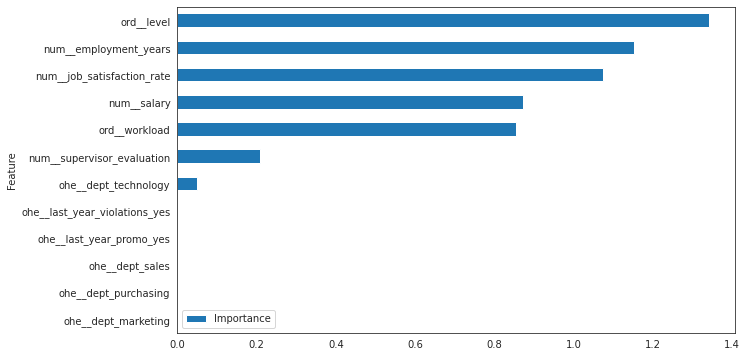

In [ ]:
# строим график важности признаков по величине коэффициентов
coefficients = model2.coef_[0]
sns.set_style('white')

feature_importance = pd.DataFrame({'Feature': df_named2.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Важными параметроми влияющими на решение об увольнении в порядке убывания: уровень должности, длительность работы в компании, уровень удовлетворённости сотрудника, размер зарплаты, уровень загруженности, оценка руководителя, принадлежность к департаменту технологий. Остальные параметры модель обнулила

<font color='blue'> <h2> <b>Общий вывод

<b>Описание задач</b><br>
<b>Первая задача</b> — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. <br>

<b> Вторая задача</b> — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.<br>

----

<b>Описание этапов работ:</b><br>
<br>
<b>Решение первой задачи было выполнено согласно следующему алгоритму:</b><br><br>
<b>1) Обучить как минимум две модели. Взять одну линейную модель, а вторую — дерево решений.</b><br>
<br>
Согласно целям алгоритма было выполнено исследование данных и выявлены следующие закономерности, которые нужно было учесть при построении модели предсказания:<br>
<br>
1.1 Целевой признак имеет количественное значение, поэтому это задача регрессии. Также ее можно решить с помощью дерева решений.<br>
Выявлены особенности данных:<br>
2.1 Признаки: level (уровень должности), workload (загруженность), last_year_promo (повышение), last_year_violations (нарушения), dept (отдел) — нужно кодировать с помощью OrdinalEncoder. («порядковый кодировщик») — кодируем с помощью OneHotEncoder<br>
3.1 При таком кодировани получится 15 зашифрованных категорий, которые можно ученьшить с помощью L1-регуляризации.<br>
4.1 В признаках, закодированных этими методами, встречаются пропуски, которые будут автоматически заменены на моду.<br>
5.1 Признаков с утечкой целевого признака на первый взгляд нет.<br>
6.1 Количественные нужно масштабировать: employment_years (стаж), supervisor_evaluation (оценка), salary (зарплата).<br>
7.1. В столбцах workload и dept встречаются пропуски - заменим на nan.<br>
7.2. Данные в обучающих и тестовых выборках соответсвуют по id, но не соответствуют по порядку.<br>
<br>
Данные выводы были учтены при построении пайплайна обработки данных. <br>
<br>
<b>2) Подобрать гиперпараметры как минимум для одной модели с помощью одного из известных инструментов.</b><br>
   Были выбраны следующие гиперпараметры для модели деревьев решений и линейной регрессии:<br>
   <br>
....#словарь для модели DecisionTreeClassifier()<br>
....{<br>
.........'models': [DecisionTreeRegressor(random_state=42)],<br>
.........'models__max_depth': range(2, 20),<br>
.........'models__min_samples_split': range(2, 5),<br>
.........'models__min_samples_leaf': range(1, 5)<br>
.....},<br>
.....# словарь для модели LogisticRegression()<br>
.....{<br>
.........'models': [LinearRegression()]  - без гиперпараметров<br>
.....},<br>

<b>3) Выбрать лучшую модель и проверить её качество. Выбор сделать на основе метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).</b><br>
<br>
3.1 Подготовлена функция вычисления метрики SMAPE.<br>
3.2 Лучшей моделью, которая выдала значение метрики на тестовых данных < 15 стала модель :<br>
<br>
Лучшие значения гиперпараметров:<br>
 {'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2}<br>
<br>
Линейные модели хорошо решают задачи в которых есть незначительный выброс в данных. Для этой задачи она в меньшей степени соответствовала, чем "дерево решений", которое фактически разгруппировало характеристики по группам, а при решении просто сопостовляло признаки с этими группами.<br>
<br>
Метрика SMAPE на тестовой выборке: 13.69<br>

<b>Решение второй задачи было выполнено согласно следующему алгоритму:</b><br>
<br>   
<b>1) Подговить данные и провести их анализ - повторяют структуру данных первого исследования.</b><br>
1.1. Данные целевого признака отличается: это quit — увольнение сотрудника из компании. Признак бинарный - поэтому будем использовать модели подходящие для этой работы: DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, SVC с соответствующими настройками гиперпараметров.
<br>
<b>2) Составить портрет «уволившегося сотрудника». </b><br>
2.1 Основная масса уволившихся - сотрудники до 3-х лет<br>
2.2 Получающие зарплату до 40 тыс.руб <br>
Максимальное соотношение уволившихся к работающим в следующих категориях (группы риска): <br>
dept: technology - 0,42<br>
level: junior - 1,06<br>
workload: low - 0,75<br>
last_year_promo: без повышения 0,41; с повышением 0,01<br>
last_year_violations: без нарушений 0,35; с нарушениями 0,72<br>
2.3 Важными параметроми влияющими на решение об увольнении в порядке убывания: уровень должности, длительность работы в компании, уровень удовлетворённости сотрудника, размер зарплаты, уровень загруженности, оценка руководителя, принадлежность к департаменту технологий.<br>
<br>     
<b>3) Подготовка данных для модели была выполнена согласно анализу данных.</b><br>  
Признаки подготовлены так же, как и в первой задаче: подготовка сделана в пайплайне.<br>
3.1. При кодировании были учтены особенности признаков и моделей и использованы два кодировщика:<br>
<br>
3.1.1 OneHotEncoder - кодирование категоральных признаков со статегией (drop='first', handle_unknown='ignore') с заменой пропусков по моде<br>
3.1.2. OrdinalEncoder - кодирование категоральных признаков без учета рангов с заменой пропусков по моде<br>
<br>
3.2 Дополнительно к данным были добавлены предсказания по оценке сотрудников места своей работы на основании первой модели.<br>
3.3 Данные в обучающих и тестовых выборках соответсвуют по id, но не соответствуют по порядку, что было учтено при работе с моделями.<br>
<br>
<b>4) Подготовлена вторая модель и выполнен поиск лучшей модели через метрику ROC_AUC для предсказания увольнения сотрудников.</b>
По проведённому анализу, лучшей моделью оказалось логистическая регрессия с параметрами:<br>
{'preprocessor__num': StandardScaler(), 'models': LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='saga')}, solver='saga')}<br>
<br>
Соревновались между собой модели четырёх типов: логистическая регрессия LogisticRegression, метод опорных векторов SVC, деревья классификации DecisionTreeClassifier и метод ближайших соседей KNeighborsClassifier.<br>
    <br>
Лоистическая регрессия заняла первое место при запуске соревнования. Так как она фактически разделила все признаки на два лагеря, статистически ровно посередине, и это она умеет делать лучше всех.<br>
    <br>
Метрика roc_auc на тестовой выборке: 0.92, что удовлетворяет условиям второй задачи > 0.91.
<br>

<b>Выводы и дополнительные предложения для бизнеса.</b><br>

Максимальное соотношение уволившихся к работающим в следующих категориях (группы риска): <br>
dept: technology - 0,42<br>
level: junior - 1,06<br>
workload: low - 0,75<br>
last_year_promo: без повышения 0,41; с повышением 0,01<br>
last_year_violations: без нарушений 0,35; с нарушениями 0,72<br>
<br>

In [ ]:
# выведем вероятности принадлежности к группе таргета
probas6 = randomized_search.predict_proba(X_test2)[:, 1]
probas6

NameError: name 'randomized_search' is not defined

In [ ]:
# совместим данные
df_quit['predict_proba'] = probas6
df_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit,predict_proba
0,485046,marketing,junior,medium,2,no,no,5,28800,0.883333,no,0.058198
1,686555,hr,junior,medium,1,no,no,4,30000,0.676667,no,0.237396
2,467458,sales,middle,low,5,no,no,4,19200,0.683750,no,0.052879
3,418655,sales,middle,low,6,no,no,4,19200,0.713333,no,0.029711
4,789145,hr,middle,medium,5,no,no,5,40800,0.815000,no,0.002899


Сегментируем данные, которые помогут бизнесу удержать перспективных сотрудников

In [ ]:
# Вероятно скоро уволятся, но имеют высокую оценку от руководителя = 4
df_quit_gut = df_quit.query('quit == "no" & predict_proba > 0.5 & job_satisfaction_rate < 0.5 & supervisor_evaluation == 4')
df_quit_gut

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit,predict_proba
244,367158,purchasing,junior,medium,1,no,no,4,21600,0.487500,no,0.563000
370,483781,technology,junior,medium,1,no,yes,4,31200,0.373333,no,0.578589
1118,808868,technology,junior,low,1,no,yes,4,19200,0.373333,no,0.865469
1262,356822,purchasing,junior,medium,1,no,no,4,21600,0.487500,no,0.563000
1445,836287,marketing,junior,medium,1,no,no,4,24000,0.490000,no,0.525697
1591,562636,hr,junior,high,1,no,no,4,33600,0.434000,no,0.822892


In [ ]:
# Вероятно скоро уволятся, так как могут иметь низкую оценку своего рабочего места
df_quit_gut = df_quit.query('quit == "no" & predict_proba > 0.5 & job_satisfaction_rate < 0.5')
df_quit_gut.shape

(44, 12)